In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import skimage
import scipy.signal
import matplotlib

In [2]:
img_sample = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\scans DICOM\NLD-AMPH-0067.dcm')
img_sample_pixel_array = sitk.GetArrayFromImage(img_sample)

seg_sample = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\segmentations ORIGINALS\NLD-AMPH-0067.nii.gz')
seg_sample_pixel_array = sitk.GetArrayFromImage(seg_sample)

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center >= radius
    mask = np.expand_dims(mask,0)
    return mask

In [4]:
frame = 0

frame_sample = seg_sample_pixel_array[frame,:,:]
frame_image = img_sample_pixel_array[frame,:,:,:]

circular_mask = create_circular_mask(frame_image.shape[0], frame_image.shape[1], radius=340)

for channel in range(3):

    frame_image[:,:,channel] = np.invert(circular_mask) * frame_image[:,:,channel]

value_seg = np.sqrt(((frame_sample.shape[0]/2.0)**2.0)+((frame_sample.shape[1]/2.0)**2.0))
polar_seg = cv2.linearPolar(frame_sample,(frame_sample.shape[0]/2, frame_sample.shape[1]/2), value_seg, cv2.WARP_FILL_OUTLIERS)
polar_seg = polar_seg.astype(np.uint16)

value_img = np.sqrt(((frame_image.shape[0]/2.0)**2.0)+((frame_image.shape[1]/2.0)**2.0))
polar_img = cv2.linearPolar(frame_image,(frame_image.shape[0]/2, frame_image.shape[1]/2), value_img, cv2.WARP_FILL_OUTLIERS)
polar_img = polar_img.astype(np.uint32)

circular_polar_img = [polar_img[:,:,channel]* circular_mask for channel in range(3)]



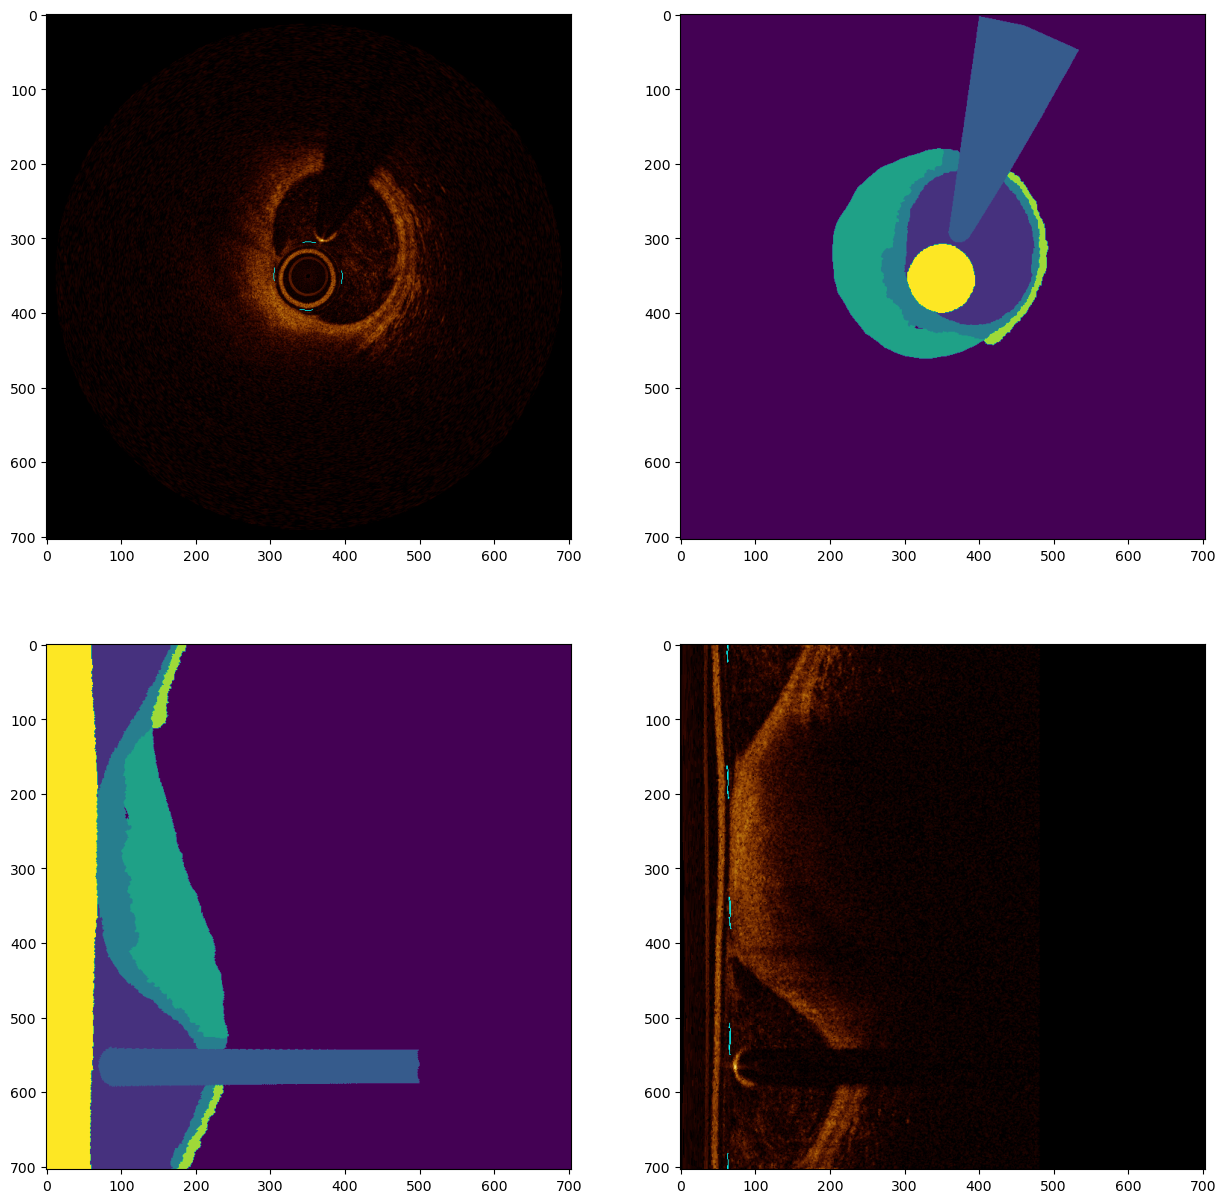

In [5]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

axes = axes.flatten()

axes[0].imshow(img_sample_pixel_array[frame,:,:,:])
axes[1].imshow(seg_sample_pixel_array[frame,:,:])
axes[2].imshow(polar_seg)
axes[3].imshow(polar_img)


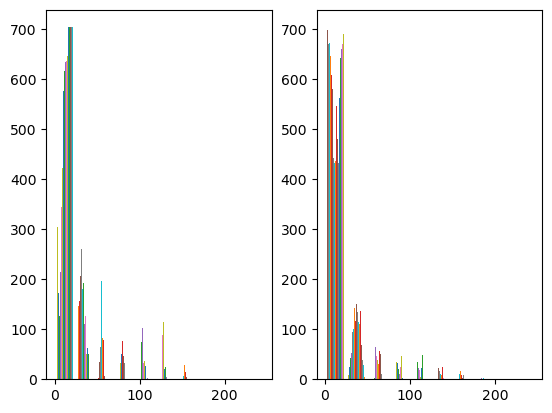

In [24]:
fig, axes = plt.subplots(1,2)

axes[0].hist(polar_img[:,:,0])
axes[1].hist(frame_image[:,:,0])
plt.show()

In [37]:
## Cost function
##1 mm = 100 px

dl = 7
dmax = 38
lamda = 7
L = 4

def create_function(img, dl = 7, dmax = 38, lamda = 7, L = 4):

    n, m, _ = img.shape
    cost = np.zeros((n, m))

    for i in range(n):
        for j in range(m-1):

            j_alphas_1 = []
            j_alphas_2 = []

            #First part
            for j_alpha1 in range(m-1):

                if j - dl <= img[i, j_alpha1, 0] <= j:
                    j_alphas_1.append(img[i, j_alpha1, 0])

                else:
                    j_alphas_1.append(0)
            
            #Second part
            for j_alpha2 in range(m-1):

                if j <= img[i, j_alpha2, 0] <= dmax:
                    j_alphas_2.append(img[i, j_alpha2, 0])

                else:
                    j_alphas_2.append(0)


            #Calculate mu
            segment = []
            segment.append(img[i, j, 0])
            for pixel in range(1, int(L/2)):
                segment.append(img[i,j+pixel,0])
                segment.append(img[i,j-pixel,0])

            #Compute cost per (i,j)
            mu = np.mean(segment)
            first_part = np.mean(j_alphas_1)
            second_part = np.mean(j_alphas_2)

            cost[i, j] =  first_part + second_part - lamda * mu

    return cost
            

In [38]:
function_cartesian = create_function(frame_image)

In [39]:
function_polar = create_function(polar_img)

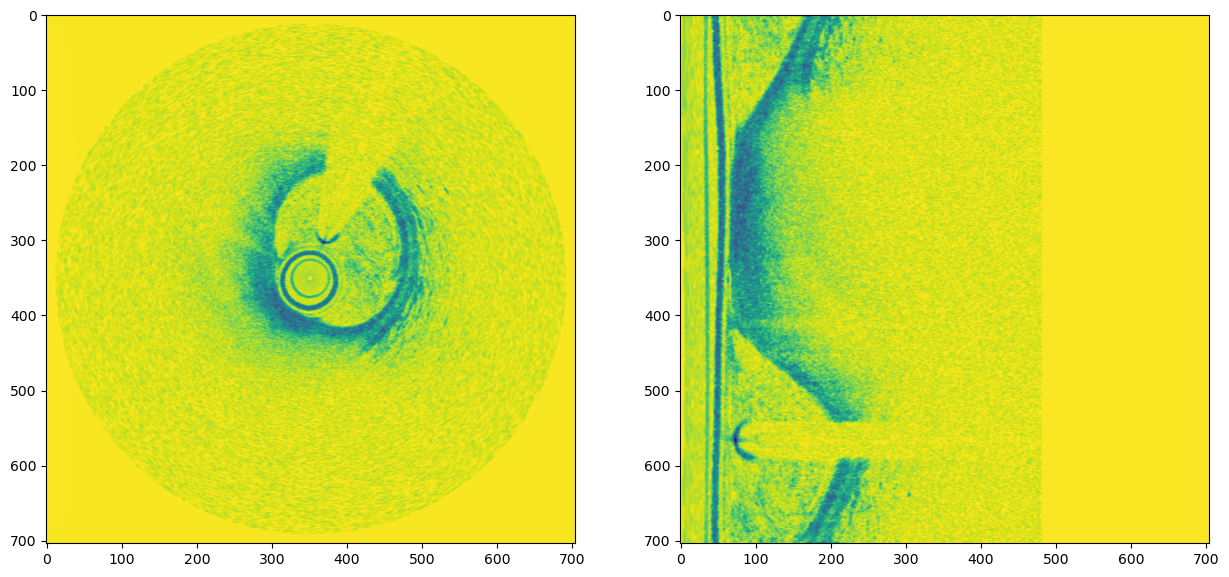

In [40]:
fig, axes = plt.subplots(1,2, figsize=(15,15))

axes = axes.flatten()

axes[0].imshow(function_cartesian)
axes[1].imshow(function_polar)